# Instration

naniwaは以下のコマンドでinstall可能

PyPIには公開していないので使うにはgithubからcloneしてください

pythonのsetuptoolsを使っているので、pipでinstall可能

In [1]:
! git clone https://github.com/q-group-work/naniwa.git
! cd naniwa
! pip install .

Cloning into 'naniwa'...
remote: Enumerating objects: 252, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 252 (delta 65), reused 223 (delta 48), pack-reused 0
Receiving objects: 100% (252/252), 58.64 KiB | 2.34 MiB/s, done.
Resolving deltas: 100% (65/65), done.
zsh:1: command not found: pip


# Usage

このライブラリでできることは、qulacs回路とIBMのqiskit回路間の相互変換と、qulacs回路とAWSのbraket回路間の相互変換である。

`QulacsConverter`を持ちいると、qulacs回路からqiskit回路やbraket回路へ変換するインスタンスが生成される。

同様に、`QiskitConverter`を使えば、qiskit回路からqulacs回路への変換ができる。

In [2]:
from naniwa import QulacsConverter
from qulacs import QuantumCircuit as qulacsQuantumCircuit
from qulacs.gate import H, CNOT

qulacs_circuit = qulacsQuantumCircuit(2)
qulacs_circuit.add_gate(H(0))
qulacs_circuit.add_gate(CNOT(0,1))
qulacs_circuit.add_gate(H(0))

print(type(qulacs_circuit))

con = QulacsConverter(qulacs_circuit)
converted_circuit = con.qiskit_convert()
print(type(converted_circuit))

converted_circuit.draw()

<class 'qulacs.QuantumCircuit'>
<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>


┌───┐     ┌───┐
q_0: ┤ H ├──■──┤ H ├
     └───┘┌─┴─┐└───┘
q_1: ─────┤ X ├─────
          └───┘

In [3]:
from naniwa import QiskitConverter
from qiskit import QuantumCircuit as qiskitQuantumCircuit

qiskit_circuit = qiskitQuantumCircuit(2)
print(type(qiskit_circuit))

con = QiskitConverter(qiskit_circuit)
converted_circuit = con.qulacs_convert()
print(type(converted_circuit))

<class 'qiskit.circuit.quantumcircuit.QuantumCircuit'>
<class 'qulacs.QuantumCircuit'>


# Demo
### 回路変換を用いたH2のVQE

ここではqulacsで作成した回路をqiskitやbraketの回路に変換して、H2のHamiltonianに対するVQEを実行してみる。

## qulacsによるVQE

まず初めにqulacsでVQEを行う

In [4]:
from qulacs import Observable, QuantumState, QuantumCircuit
import numpy as np
import matplotlib.pyplot as plt

原子間距離 0.735 Aの水素モデルのHamiltonianとして、以下を考える。

In [5]:
nqubits = 2
qulacs_hamiltonian= Observable(nqubits)
qulacs_hamiltonian.add_operator(-1.052373245772859, "I 0 I 1")
qulacs_hamiltonian.add_operator(0.39793742484318045, "I 0 Z 1")
qulacs_hamiltonian.add_operator(-0.39793742484318045, "Z 0 I 1")
qulacs_hamiltonian.add_operator(-0.01128010425623538, "Z 0 Z 1")
qulacs_hamiltonian.add_operator(0.18093119978423156, "X 0 X 1")


qulacsによる変分回路の生成

今回は以下のような回路を用いる。(qiskitではcircuit libraryのTwoLocal関数で生成できる回路)
```
     ┌──────────┐   ┌──────────┐   ┌──────────┐   ┌──────────┐
q_0: ┤ RY(θ[0]) ├─■─┤ RY(θ[2]) ├─■─┤ RY(θ[4]) ├─■─┤ RY(θ[6]) ├
     ├──────────┤ │ ├──────────┤ │ ├──────────┤ │ ├──────────┤
q_1: ┤ RY(θ[1]) ├─■─┤ RY(θ[3]) ├─■─┤ RY(θ[5]) ├─■─┤ RY(θ[7]) ├
     └──────────┘   └──────────┘   └──────────┘   └──────────┘
```

In [6]:
from qulacs.gate import RY, CZ

def QulacsCircuit(angle, nqubits=2):
    ansatz = QuantumCircuit(nqubits)
    for i in range(2):
        ansatz.add_gate(RY(0, angle[i]))
        ansatz.add_gate(RY(1, angle[i+1]))
        ansatz.add_gate(CZ(0,1))
        ansatz.add_gate(RY(0, angle[i+2]))
        ansatz.add_gate(RY(1, angle[i+3]))
    return ansatz
    

コスト関数の定義

In [7]:
def cost_qulacs(parameters):
    #初期波動関数の用意
    state = QuantumState(nqubits) 
    #ansatz(量子回路を用意)
    ansatz = QulacsCircuit(parameters)
    ansatz.update_quantum_state(state)
    return qulacs_hamiltonian.get_expectation_value(state) 


VQEの実行

Convderged VQE Energy (in hartree) -1.8572750068582877


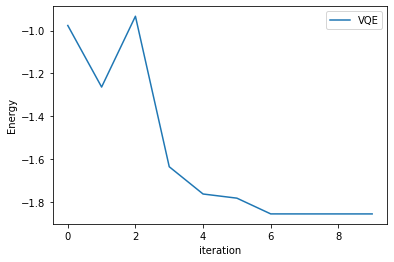

In [8]:
import scipy

init_theta_list = np.random.random(4*nqubits)
qulacs_cost_history = []    
qulacs_cost_history.append(cost_qulacs(init_theta_list))

method = "SLSQP"
options = {"disp": True, "maxiter": 1000, "gtol": 1e-10}

opt = scipy.optimize.minimize(cost_qulacs, init_theta_list,
            method=method,
            callback=lambda x: qulacs_cost_history.append(cost_qulacs(x)))

print ("Convderged VQE Energy (in hartree)", qulacs_cost_history[-1])
init_theta_list = opt.x

plt.plot(qulacs_cost_history, label="VQE")
plt.ylabel("Energy")
plt.xlabel("iteration")
plt.legend()
plt.show()

## qulacsの回路をqiskitの回路に変換してVQEを実行

In [9]:
con = QulacsConverter(QulacsCircuit(init_theta_list, nqubits=2))
qiskit_ansatz = con.qiskit_convert(parameterized=True)
qiskit_ansatz.draw()

┌────────┐   ┌────────┐┌────────┐   ┌────────┐
q_0: ┤ Ry(θ0) ├─■─┤ Ry(θ2) ├┤ Ry(θ4) ├─■─┤ Ry(θ6) ├
     ├────────┤ │ ├────────┤├────────┤ │ ├────────┤
q_1: ┤ Ry(θ1) ├─■─┤ Ry(θ3) ├┤ Ry(θ5) ├─■─┤ Ry(θ7) ├
     └────────┘   └────────┘└────────┘   └────────┘

Hamiltonianの作成

In [10]:
from qiskit.opflow import X, Z, I
H2_op = (-1.052373245772859 * I ^ I) + \
        (0.39793742484318045 * I ^ Z) + \
        (-0.39793742484318045 * Z ^ I) + \
        (-0.01128010425623538 * Z ^ Z) + \
        (0.18093119978423156 * X ^ X)


期待値の測定用関数

cost関数の定義

VQEの実行

In [11]:
from qiskit import Aer
from qiskit.opflow import X, Z, I
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)

con = QulacsConverter(QulacsCircuit(init_theta_list, nqubits=2))
ansatz = con.qiskit_convert(parameterized = True)
slsqp = SLSQP(maxiter=1000)
vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)
qiskit_result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print("Convderged VQE Energy (in hartree)", qiskit_result.optimal_value)
# optimizer_evals = result.optimizer_evals


Convderged VQE Energy (in hartree) -1.8572748018995862


/Users/cafey/git/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/cafey/git/lib/python3.9/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


## Braketで実行

Hamiltonianの計算とcost関数の作成

In [12]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice

ansatzの生成

In [13]:
from naniwa import QulacsConverter_2_Braket

braket_class = QulacsConverter_2_Braket(QulacsCircuit(init_theta_list, nqubits=2))
BraketCircuit = braket_class.braket_convert()
print(BraketCircuit)

T  : |    0    |1|   2    |    3    |4|    5    |
                                                 
q0 : -Ry(-1.01)-C-Ry(1.11)-Ry(0.997)-C-Ry(1.44)--
                |                    |           
q1 : -Ry(0.997)-Z-Ry(1.44)-Ry(1.11)--Z-Ry(0.772)-

T  : |    0    |1|   2    |    3    |4|    5    |


In [14]:
from naniwa import QulacsConverter_2_Braket
    
def cost_braket(params):
    braket_class = QulacsConverter_2_Braket(QulacsCircuit(params, nqubits=2))
    BraketCircuit = braket_class.braket_convert()
    # set up device: Local Simulator
    device = LocalSimulator()
    # add the Z \otimes Z \otimes Z expectation value
    BraketCircuit.expectation(Observable.I() @ Observable.I(), target=[0,1])
    BraketCircuit.expectation(Observable.Z(), target=[0])
    BraketCircuit.expectation(Observable.Z(), target=[1])
    BraketCircuit.expectation(Observable.Z() @ Observable.Z(), target=[0,1])
    BraketCircuit.expectation(Observable.X() @ Observable.X(), target=[0,1])

    # H2_op = (-1.052373245772859 * I ^ I) + \
    #         (0.39793742484318045 * I ^ Z) + \
    #         (-0.39793742484318045 * Z ^ I) + \
    #         (-0.01128010425623538 * Z ^ Z) + \
    #         (0.18093119978423156 * X ^ X)

    task = device.run(BraketCircuit, shots=0)
    result = task.result()
    conj = [-1.052373245772859, 0.39793742484318045, -0.39793742484318045, -0.01128010425623538, 0.18093119978423156]
    cost = 0.0
    for i, exp in  enumerate(result.values):
        cost+=conj[i]*exp
    return cost

Convderged VQE Energy (in hartree) -1.8572750081903346


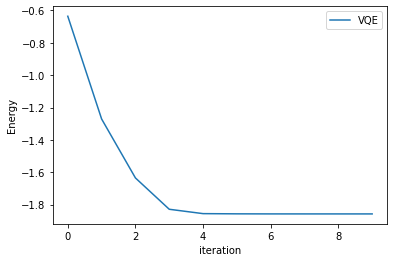

In [15]:
import scipy

vqe_energies = []
init_theta_list = np.random.random(4*nqubits)
braket_cost_history = []    
braket_cost_history.append(cost_braket(init_theta_list))

method = "SLSQP"
options = {"disp": True, "maxiter": 1000, "gtol": 1e-10}

opt = scipy.optimize.minimize(cost_braket, init_theta_list,
            method=method,
            callback=lambda x: braket_cost_history.append(cost_braket(x)))

print ("Convderged VQE Energy (in hartree)", braket_cost_history[-1])

init_theta_list = opt.x

plt.plot(braket_cost_history, label="VQE")
plt.ylabel("Energy")
plt.xlabel("iteration")
plt.legend()
plt.show()

Convderged VQE Energy in qulacs (in hartree) -1.8572750068582877
Convderged VQE Energy in qiskit (in hartree) -1.8572748018995862
Convderged VQE Energy in braket (in hartree) -1.8572750081903346


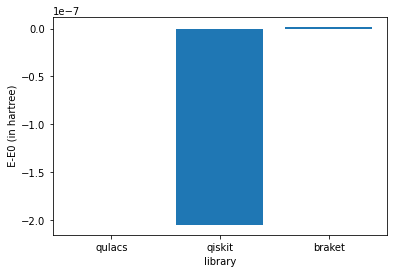

In [19]:
energys = {"qulacs":-qulacs_cost_history[-1], "qiskit":-qiskit_result.optimal_value, "braket":-braket_cost_history[-1]}

print ("Convderged VQE Energy in qulacs (in hartree)", qulacs_cost_history[-1])
print("Convderged VQE Energy in qiskit (in hartree)", qiskit_result.optimal_value)
print ("Convderged VQE Energy in braket (in hartree)", braket_cost_history[-1])

plt.bar(energys.keys(), [energys[k]-1.8572750068582877 for k in energys.keys()])
plt.xlabel('library')
plt.ylabel(' E-E0 (in hartree)')
# plt.yscale('log')
plt.show()